<a href="https://colab.research.google.com/github/Varun-Haris/Music-genre-recognition-using-Keras/blob/master/CRNN_final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers

import librosa
import librosa.display

import cv2
from google.colab import drive

import os

from sklearn.model_selection import train_test_split

path = '/content/gdrive/My Drive/'

drive.mount('/content/gdrive', force_remount=True)

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }


reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [0]:
npzfile = np.load(path+'shuffled_train.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394, 8)


In [0]:
npzfile = np.load(path+'shuffled_valid.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800, 8)


Electronic


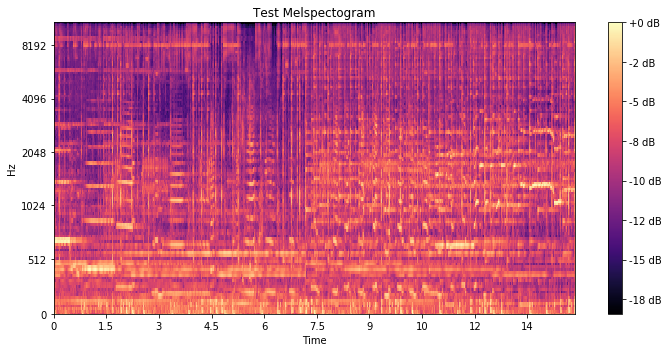

In [0]:
num = 4126
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

In [0]:
batch_size = 32
num_classes = 8
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [0]:
def CRNN_network(N_LAYERS, FILTER_LENGTH, CONV_FILTER_COUNT, LSTM_COUNT, dropout, L2_regularization, NUM_HIDDEN, Learning_rate):
    
    input_shape = (None, n_features)
    model_input = Input(input_shape, name='input')
    
    print('Building model...')
    layer = model_input
    
    ### 3 1D Convolution Layers
    for k in range(N_LAYERS):
        # give name to the layers
        layer = Conv1D(
                filters=CONV_FILTER_COUNT*(2**k),
                kernel_size=FILTER_LENGTH,
                kernel_regularizer=regularizers.l2(L2_regularization),  # Tried 0.001
                name='convolution_' + str(k + 1)
            )(layer)
        layer = BatchNormalization(momentum=0.9)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(dropout)(layer)
    
    ## LSTM Layer
    layer = LSTM(LSTM_COUNT, return_sequences=False)(layer)
    layer = Dropout(dropout)(layer)
    
    ## Dense Layer
    layer = Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_regularization), name='dense1')(layer)
    layer = Dropout(dropout)(layer)
    
    ## Softmax Output
    layer = Dense(num_classes)(layer)
    layer = Activation('softmax', name='output_realtime')(layer)
    model_output = layer
    model = Model(model_input, model_output)
    
    
    opt = Adam(lr=Learning_rate)
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=15, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(X_valid, y_valid), verbose=1, callbacks=callbacks_list)

    return model, history

In [0]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [0]:
N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 16
BATCH_SIZE = 32
LSTM_COUNT = 128
EPOCH_COUNT = 70
NUM_HIDDEN = 512
L2_regularization = 0.01
Learning_rate = 0.001
DROPOUT = .3

model, history = CRNN_network(N_LAYERS, FILTER_LENGTH, CONV_FILTER_COUNT, LSTM_COUNT, DROPOUT, L2_regularization, NUM_HIDDEN, Learning_rate)


Building model...




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 128)         0         
_________________________________________________________________
convolution_1 (Conv1D)       (None, None, 16)          10256     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 16)          64        
_________________________________________________________________
activation_1 (Activation)    (None, None, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 16)      

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


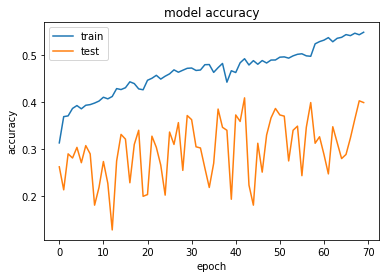

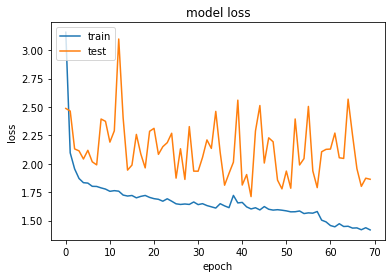

In [0]:
show_summary_stats(history)

In [0]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis = 1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.36      0.47      0.41       100
 Experimental       0.34      0.33      0.33       100
         Folk       0.68      0.53      0.60       100
      Hip-Hop       0.50      0.02      0.04       100
 Instrumental       0.36      0.58      0.44       100
International       0.32      0.78      0.46       100
          Pop       0.25      0.08      0.12       100
         Rock       0.73      0.40      0.52       100

     accuracy                           0.40       800
    macro avg       0.44      0.40      0.36       800
 weighted avg       0.44      0.40      0.36       800



In [0]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.39875


In [0]:

from keras.models import load_model

weights_path = '/content/weights.best.h5'
model = load_model(weights_path)

In [0]:
npzfile = np.load(path+'test_arr.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [0]:
y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

0 7 3.5


In [0]:

X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

1e-08 1.0000000000000016 0.004623813018385694


In [0]:
X_test = np.log(X_test_raw)


from sklearn.metrics import classification_report

y_true = y_test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.62      0.37      0.46       100
 Experimental       0.18      0.19      0.19       100
         Folk       0.15      0.41      0.22       100
      Hip-Hop       0.53      0.75      0.62       100
 Instrumental       0.45      0.14      0.21       100
International       0.33      0.09      0.14       100
          Pop       0.36      0.20      0.26       100
         Rock       0.52      0.60      0.56       100

     accuracy                           0.34       800
    macro avg       0.39      0.34      0.33       800
 weighted avg       0.39      0.34      0.33       800



In [0]:
y_test = keras.utils.to_categorical(y_test, num_classes=8)
model.evaluate(X_test, y_test)

800/800 [==============================] - 1s 2ms/step


[1.9544586944580078, 0.34375]

In [0]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_true, y_pred))

[[37  7 15 22  1  1 11  6]
 [ 7 19 37  3 13  6  3 12]
 [ 0 50 41  0  0  1  3  5]
 [ 5  1  6 75  2  0 10  1]
 [ 4 15 51  2 14 10  0  4]
 [ 2  5 42 16  1  9  6 19]
 [ 4  3 44 20  0  0 20  9]
 [ 1  5 29  3  0  0  2 60]]


In [0]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.34375


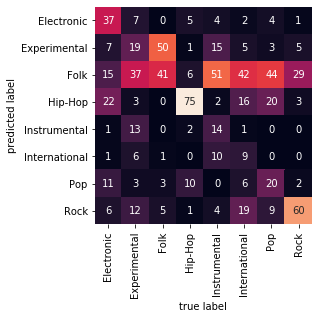

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');

In [0]:
from google.colab import files
files.download('/content/weights.best.h5')